<a href="https://colab.research.google.com/github/devparikh0506/DATA-602/blob/main/week_9/Homework_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preamble

In [1]:
from google.colab import drive
import numpy as np
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For convenience, the `plot_silhouette` function discussed in class is below.

In [2]:
import matplotlib.cm as cm
def plot_silhouette(samples,
                    labels,
                    ax=None,
                    cmap='Dark2'):
  if (ax is None):
    ax = plt.gca()

  # sort samples by label, and add index
  df = (np
     .c_[samples, labels]
     .view(dtype=[("samples", float), ("labels", float)]))
  df.sort(axis=0, order=["labels", "samples"])
  df = np.c_[df.view(float), np.arange(df.shape[0])]

  # bar plot
  z = ax.barh(df[:,2], df[:,0], 1)

  #color map for plotting
  cmap = cm.get_cmap(cmap)

  #set bar colors
  maxcluster = np.max(df[:, 1])
  for ix, k in enumerate(df):
    z[ix].set_color(cmap(k[1]/maxcluster))

  #label y axis ticks
  yticks = []
  yticklabels = []

  bounds = np.r_[np.argwhere(np.diff(df[:,1], prepend=[0]) > 0).ravel(),
                 df.shape[0]].ravel()
  for ix, b in enumerate(bounds):
    low = bounds[ix - 1] if ix > 0 else 0
    high = b
    yticks.append((low + high)/2)
    yticklabels.append(df[low,1].astype(labels.dtype))

  #axis decorations
  bounds, yticks, yticklabels
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels)
  ax.grid()
  ax.set_ylabel("Cluster")
  ax.set_xlabel("Silhouette")
  return ax

# Problem 1

In the 602 shared drive, the file /data/cluster.txt contains a features matrix $\mathbf{X}\in\mathbb{R}^{10,000\times20}$.  (You can use `np.loadtxt` to read the file as a numpy matrix.)  This features was generated from scikit-learn's `make_blobs` function with parameters of `n_features=20` and centers uniformly distributed in $[-5, 5]$ along each axis.  The dataset was produced with at least 5 but no more than 15 clusters.  Find the number of clusters used to generate the dataset (i.e., $k$ that best clusters the data), and justify your conclusion using silhouette plots.


In [3]:
X = np.loadtxt('/content/drive/Shareddrives/DS602-F22/Data/cluster.txt')

For this problem first let's find best value for K using elbow method

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

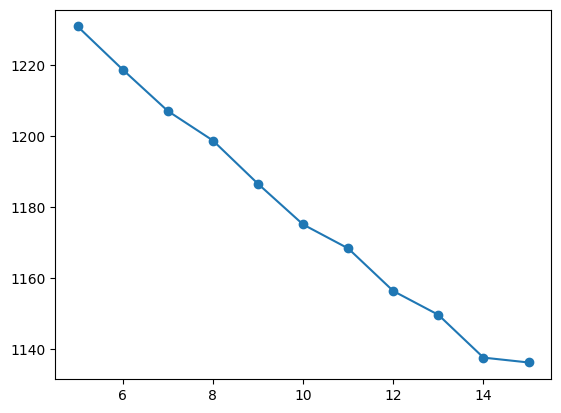

In [7]:
scores = []
silscores = []
for k in range(5, 16):
  km = KMeans(k, n_init='auto')
  km.fit(X)
  labels = km.predict(X)
  scores.append([k, km.inertia_])
  silscores.append([k, silhouette_score(X, labels)])
s = np.c_[scores]
plt.plot(s[:,0], s[:,1], 'o-')

From above graph we can see that K=5 is the point after which the SSE stays almost same. Hence we can say that 5 clusters were used for creating the dataset but let's verify our elbow method results with silhoutte plots

<ipython-input-2-c252af4bb257>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)
<ipython-input-2-c252af4bb257>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)
<ipython-input-2-c252af4bb257>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)
<ipython-input-2-c252af4bb257>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases late

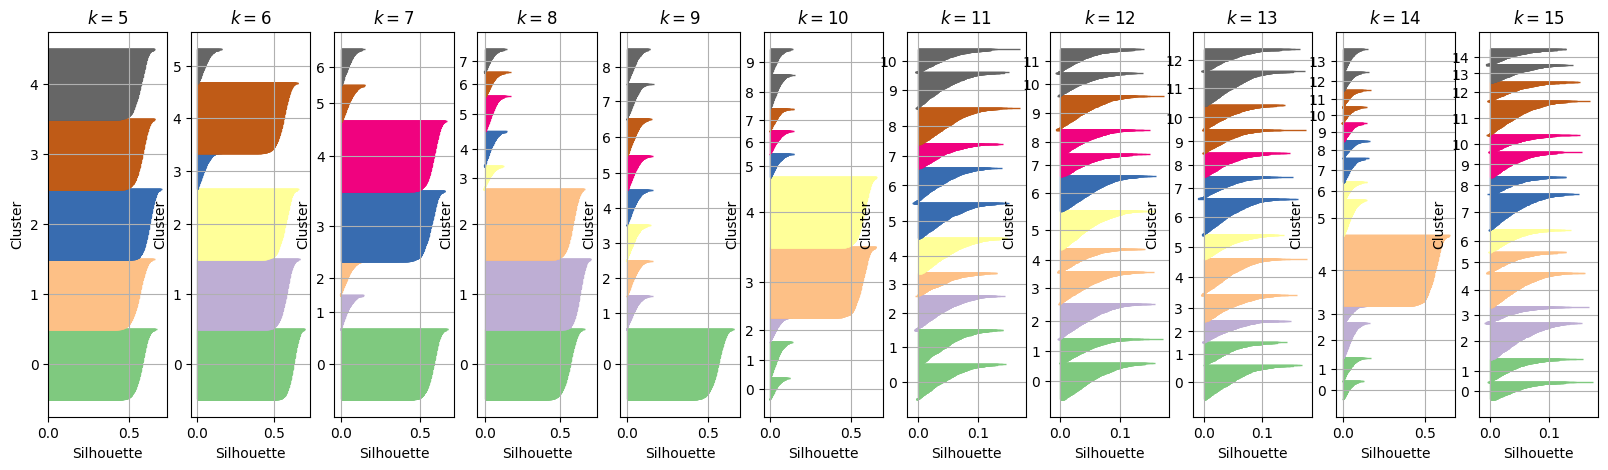

In [6]:
fig, ax = plt.subplots(1, 11, figsize=(20,5))
for ix, ax in enumerate(ax.ravel()):
  nclusters = ix + 5
  if nclusters > 15:
    break
  km = KMeans(nclusters, n_init='auto')
  km.fit(X)
  labels = km.predict(X)
  silvals = silhouette_samples(X, labels)
  plot_silhouette(silvals, labels, cmap='Accent', ax=ax)
  ax.set_title(f"$k={nclusters}$")

Analyzing above Silhouette plots we can clearly see that only K=5 gives high and consistant scores for all clusters. Hence we can say that 5 clusters were used for creating the dataset and this justifies the elbow graph we plotted above.

# Problem 2
The Fashion-MNIST dataset is a dataset of 10,000 grayscale images of size $28\times28$.  Each image depicts an article of clothing.  Load the dataset from OpenML (the dataset name is "Fashion-MNIST") and retain only the first 5,000 images.  Find an optimal number of Gaussian components based on the Akaike Information Criterion (AIC), and use the AIC scores to cluster the data using a GMM.  Visually inspect the model outcomes.  Is the clustering the model selected meaningful (e.g., are the cluster separations intuitive)?

In [16]:
from sklearn.datasets import fetch_openml
X, _ = fetch_openml("Fashion-MNIST", return_X_y=True, as_frame=False)
# keep only the first 5,000 images
X = X[:5000,:]

In [11]:
from sklearn.mixture import GaussianMixture
import pandas as pd

In [35]:
# Reference taken from class materials
recs = []
comps = np.arange(2, 31)
for k in comps:
  gmm = GaussianMixture(n_components=k)
  gmm.fit(X)
  recs.append([k,
               gmm.aic(X)
               ])

aicdf = pd.DataFrame(recs, columns=["k", "AIC"])
aicdf.set_index("k", inplace=True)
aicdf.style.background_gradient(axis=0, cmap="Blues_r")

,AIC
k,
2,33131036.438017
3,27834788.118976
4,28428226.227030
5,26565854.749195
6,20592815.613146
7,15718783.219467
8,14450185.039863
9,11482016.007228
10,8241094.587925


In [37]:
optimal_n_components = range(2,31)[np.argmin(aicdf['AIC'])]
print(f"Optimal number of components: {optimal_n_components}")

Optimal number of components: 28


Text(0, 0.5, 'Information Criteria')

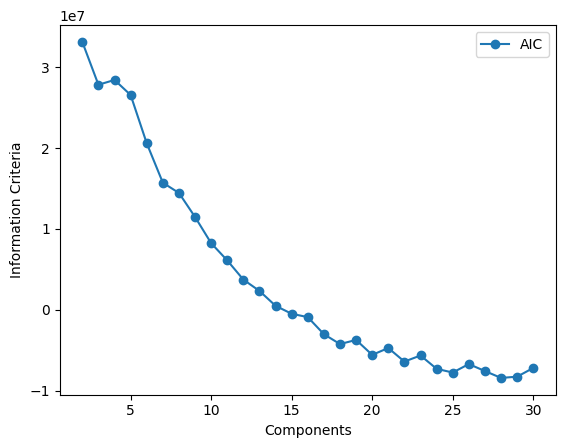

In [38]:
# Reference taken from class materials
plt.plot(aicdf.index, aicdf["AIC"], label='AIC', marker='o')
ax = plt.gca()
ax.legend()
ax.set_xlabel("Components")
ax.set_ylabel("Information Criteria")

From above results we found 28 as optimal number of gaussian components using AIC

In [56]:
# Using n_components=28
gmm = GaussianMixture(n_components=optimal_n_components)
gmm.fit(X)

# Predicting labels
labels = gmm.predict(X)

Let's visualize the results

First plotting clusters on 2d graph using PCA

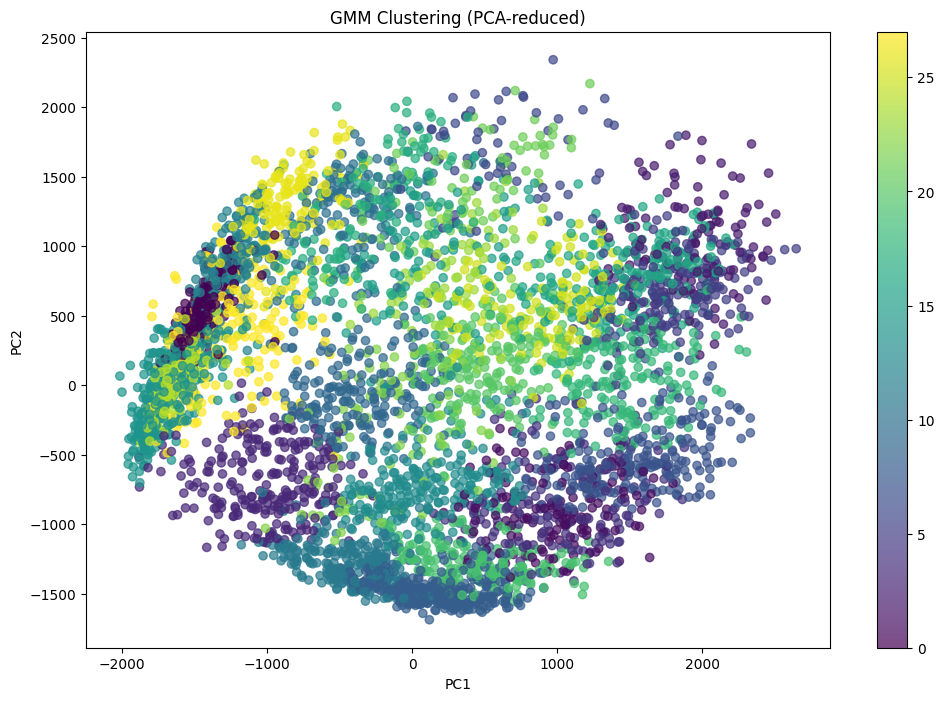

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('GMM Clustering (PCA-reduced)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

The clusters looking so congested so now let's check few images for each cluster

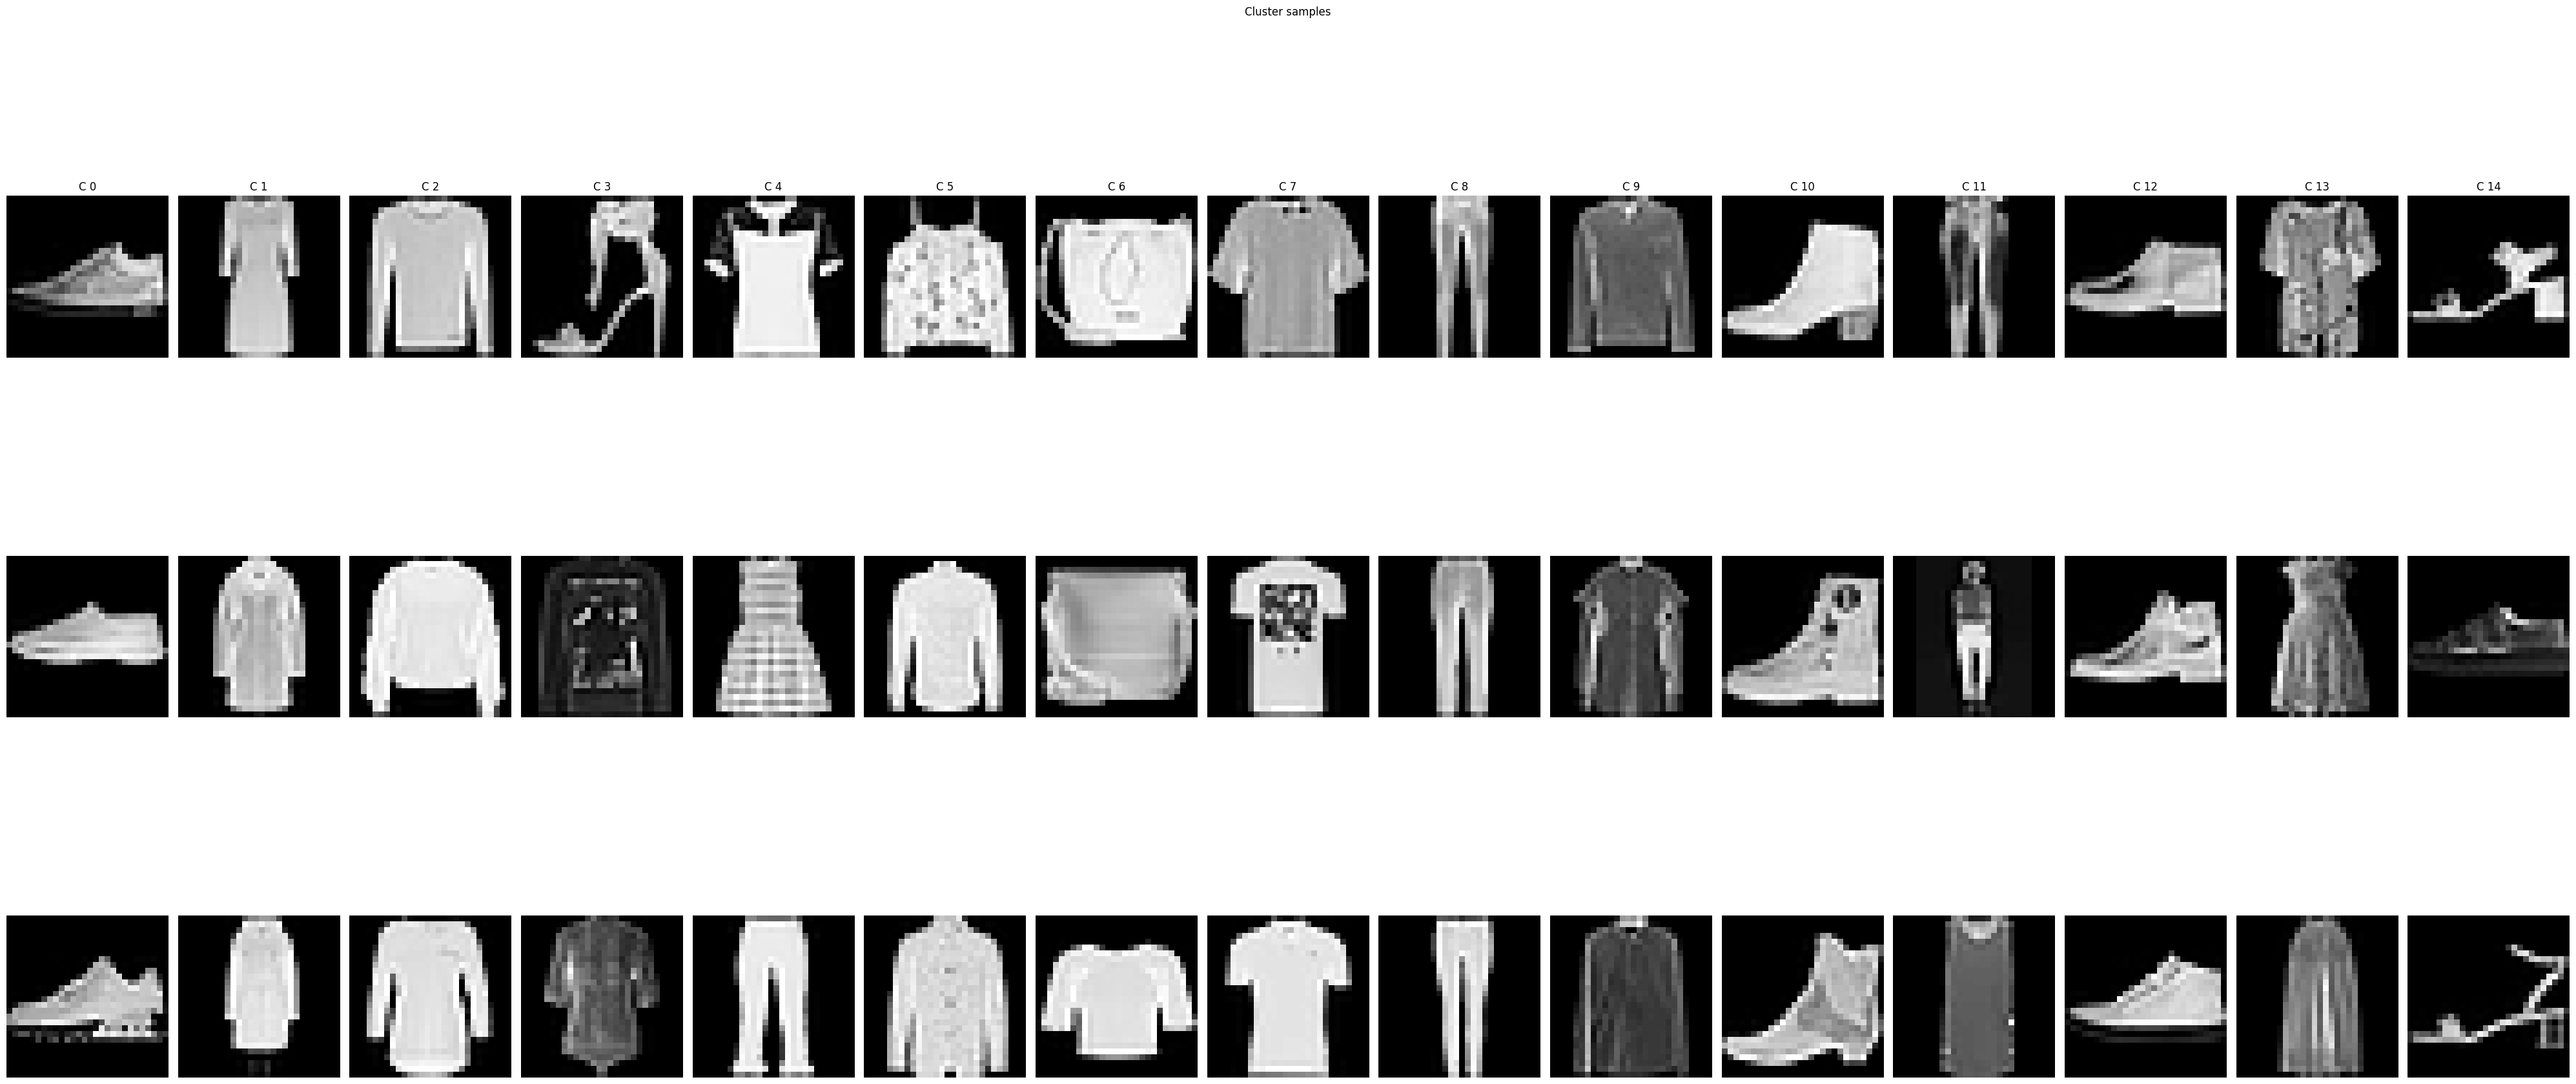

In [58]:
# Display some example images from each cluster
n_rows = 3
n_cols = optimal_n_components
fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 20))
fig.suptitle("Cluster samples")

for i in range(optimal_n_components):
    cluster_images = X[labels == i]
    for j in range(min(n_rows, len(cluster_images))):
        idx = np.random.randint(len(cluster_images))
        axes[j, i % n_cols].imshow(cluster_images[idx].reshape(28, 28), cmap='gray')
        axes[j, i % n_cols].axis('off')
        if j == 0:
            axes[j, i % n_cols].set_title(f'C {i}')

plt.tight_layout()
plt.show()

# Problem 3
Import the MNIST-784 dataset (handwritten numbers), and keep only observations labeled as "7".   Using an outlier detection method of your choice, identify outlier observations, i.e., observations that do not resemble other observations in the dataset.  Display a sample of 5-10 detected outlier observations.

For this question I will use PCA reconstruction method

In [122]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [119]:
X_, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

Let's take observations with '7' as target

In [120]:
X = X_[y == '7']

Using standard scalar for scaling

In [121]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now taking 75% of total variance for PCA

In [102]:
pca = PCA(n_components=0.75)
X_pca = pca.fit_transform(X_scaled)

Reconstructing pca and calculating mean squared error

In [125]:
X_reconstructed=pca.inverse_transform(X_pca)
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed, multioutput='raw_values')

Taking only top 9 outliers

In [162]:
max_err_scores = np.argsort(reconstruction_error)[-9:]

Plotting top 9 outliers

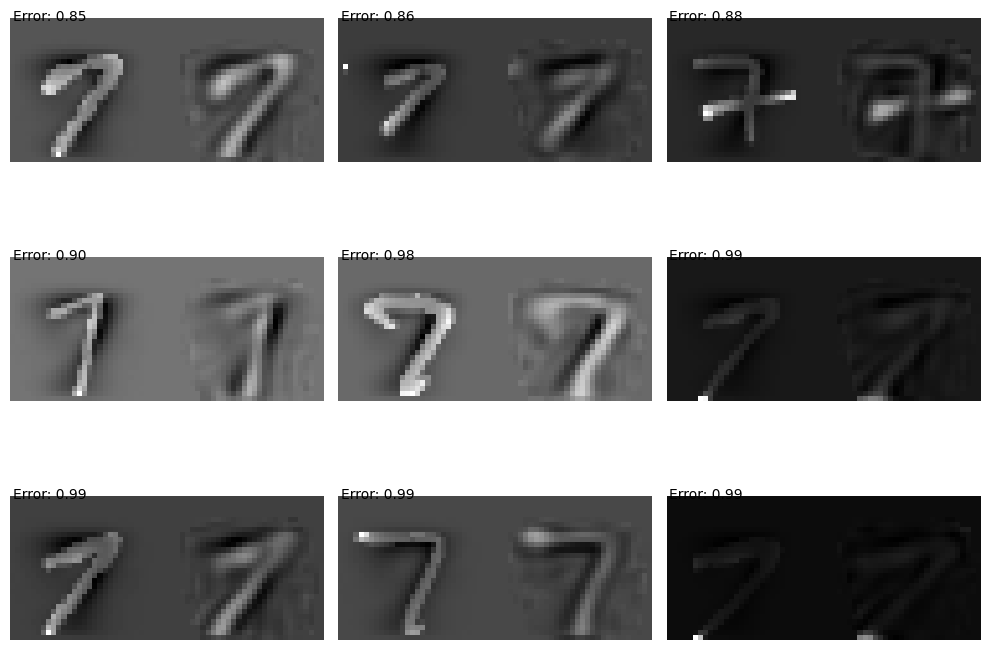

In [164]:
fig, axs = plt.subplots(3,3, figsize=(10,8))
axs = axs.reshape(-1)
h=w=28
for ix, ax in enumerate(axs):
  ax.imshow(
      np.c_
      [
        X_scaled[ix].reshape(h, w),
        np.zeros((h, 5)),
        X_reconstructed[ix].reshape(h, w)
      ], cmap='gray')
  ax.annotate(f"Error: {reconstruction_error[max_err_scores[ix]]:.2f}", (0,0))
  ax.set_axis_off()

plt.tight_layout()
plt.show()